<a href="https://colab.research.google.com/github/meghutch/Breast-Cancer-Classification-Clinical-Genomic/blob/master/Predicting_Clinical_Outcomes_of_Breast_Cancer_Patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Clinical Outcomes of Breast Cancer Patients**

**Author:** Meg Hutch

**Date:** October 31, 2019

**Objective:** Examining the data from Lee's ML course

This project will investigate predicting the survival of patients diagnosed with breast cancer using
the METABRIC (Molecular Taxonomy of Breast Cancer International Consortium) dataset [1, 2].
METABRIC contains clinical and demographic data, DNA sequencing, copy-number, and gene
expression data for over 2000 patients.

**The first part of this analysis will examine whether low dimensional clinical data can be used to predict survivial (binary classification)**

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [2]:
# Connect Colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import Data
bc_data = pd.read_csv('/content/drive/My Drive/Projects/Breast_Cancer_Classification/Data/data_clinical_patient.csv')

In [0]:
#bc_data.head()

# **Pre-Process Data**




Rows 0-3 contain definitions of data and data types. We can remove these

In [0]:
bc_data = bc_data.iloc[4:]

Convert first row to header name

In [0]:
# Convert first row to header name
bc_data = bc_data.rename(columns=bc_data.iloc[0]).drop(bc_data.index[0])

Convert column names to lowercase

In [0]:
# Convert column names to lowercase
bc_data.columns = map(str.lower, bc_data.columns)

# **Explore Data**

**Total Number of Patients**

In [8]:
print('Total Number of Patients:', len(bc_data.index))

Total Number of Patients: 2509


**Remove any incomplete cases**

In [0]:
bc_data = bc_data.dropna()

**Re-Examine Total Number of Patients**

In [10]:
print('Total Number of Patients after Removing NAs:', len(bc_data.index)) # This removes about 1000 patients from the analysis 

Total Number of Patients after Removing NAs: 1519


**In the project directions, it says we can treat "Died of Other Causes" as living. Thus, change the category title as such.**

In [0]:
bc_data['vital_status'] = bc_data['vital_status'].replace({'Living': 'Living', 'Died of Disease': 'Died of Disease', 'Died of Other Causes': 'Living'})

**Examine Variable Names**

In [12]:
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 6 to 1985
Data columns (total 21 columns):
patient_id                       1519 non-null object
lymph_nodes_examined_positive    1519 non-null object
npi                              1519 non-null object
cellularity                      1519 non-null object
chemotherapy                     1519 non-null object
cohort                           1519 non-null object
er_ihc                           1519 non-null object
her2_snp6                        1519 non-null object
hormone_therapy                  1519 non-null object
inferred_menopausal_state        1519 non-null object
intclust                         1519 non-null object
age_at_diagnosis                 1519 non-null object
os_months                        1519 non-null object
os_status                        1519 non-null object
claudin_subtype                  1519 non-null object
threegene                        1519 non-null object
vital_status                 

**Examine Variable Distributions**

Text(0.5, 1.0, 'Histological Subtype')

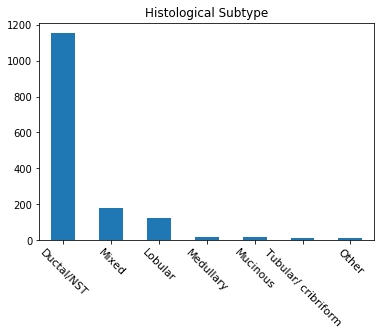

In [13]:
plt1 = bc_data.histological_subtype.value_counts().plot(kind="bar")
plt1.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt1.set_title("Histological Subtype")

Text(0.5, 1.0, 'Survival')

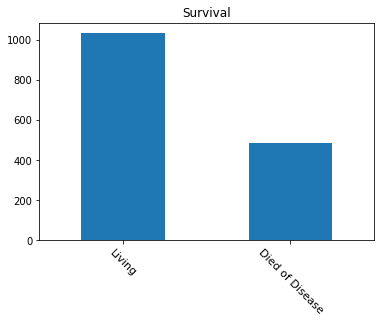

In [14]:
plt2 = bc_data.vital_status.value_counts().plot(kind="bar")
plt2.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt2.set_title("Survival")

Text(0.5, 1.0, 'Three Gene Classifier')

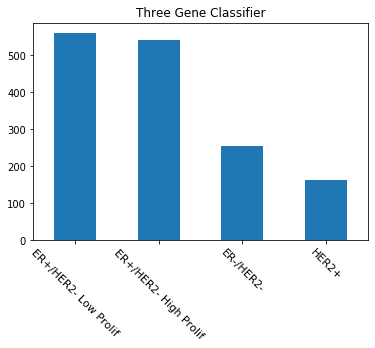

In [15]:
plt3 = bc_data.threegene.value_counts().plot(kind="bar")
plt3.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt3.set_title("Three Gene Classifier")

Text(0.5, 1.0, 'Cellularity')

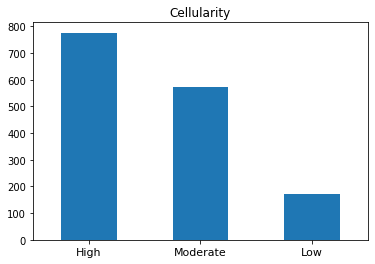

In [16]:
plt4 = bc_data.cellularity.value_counts().plot(kind="bar")
plt4.tick_params(axis="x", labelsize=11, labelrotation= 360)
plt4.set_title("Cellularity")

Text(0.5, 1.0, 'Chemotherapy')

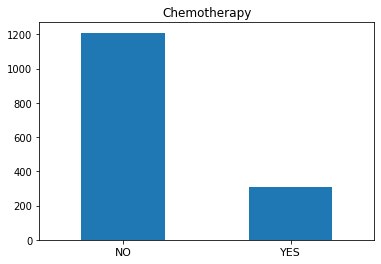

In [17]:
plt5 = bc_data.chemotherapy.value_counts().plot(kind="bar")
plt5.tick_params(axis="x", labelsize=11, labelrotation= 360)
plt5.set_title("Chemotherapy")

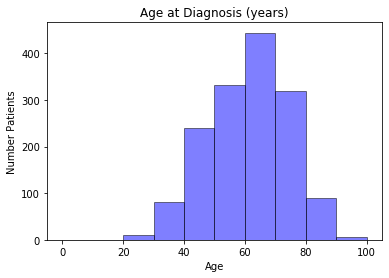

In [18]:
# Convert object to float
age = bc_data['age_at_diagnosis'].astype(float)

# Define bins
bin_edges = [0,10,20,30,40,50,60,70,80,90,100]

plt.hist(age,
         bins=bin_edges,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('Age')
plt.ylabel('Number Patients')
plt.title('Age at Diagnosis (years)')

plt.show()

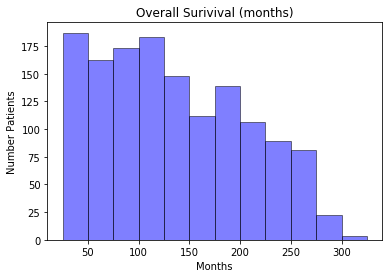

In [19]:
# Convert object to float
os = bc_data['os_months'].astype(float)

# Define bins
bin_edges = [25,50,75,100,125,150,175,200,225,250,275,300,325]

plt.hist(os,
         bin_edges,
         density=False,
         histtype='bar',
         color='b',
         edgecolor='k',
         alpha=0.5)

plt.xlabel('Months')
plt.ylabel('Number Patients')
plt.title('Overall Surivival (months)')

plt.show()

**Examine Patient Outcomes**

vital_status
Died of Disease     485
Living             1034
dtype: int64
Percent Living: 0.7
Percent Died of Disease: 0.3


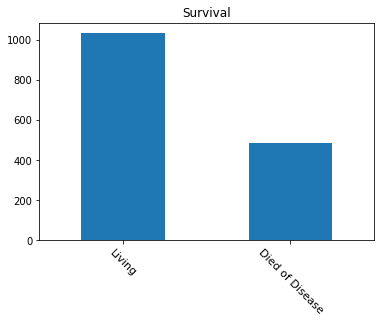

In [20]:
plt_out = bc_data.vital_status.value_counts().plot(kind="bar")
plt_out.tick_params(axis="x", labelsize=11, labelrotation= -45)
plt_out.set_title("Survival")

# Calculate Percents
count_outcomes = bc_data.groupby(['vital_status']).size()
print(count_outcomes)

print('Percent Living: {:.1f}'.format(count_outcomes["Living"]/len(bc_data.index)))
print('Percent Died of Disease: {:.1f}'.format(count_outcomes["Died of Disease"]/len(bc_data.index)))

# **Pre-Process Data**#

Because some categorical features have multiple categories, we need to use one-hot-encoding to represent these varaibles in the dataset. Just creating numeric levels won't always make sense in the case of features like caludin_subtype which are genomic classifications

In [21]:
# Determine which variables we want to one-hot-encode
print('Cellularity:', bc_data['cellularity'].unique())
print('Chemotherapy:',bc_data['chemotherapy'].unique())
print('Er_ihc:',bc_data['er_ihc'].unique())
print('Her2_snp6:',bc_data['her2_snp6'].unique())
print('Hormone Therapy:',bc_data['hormone_therapy'].unique())
print('Inferred_menopausal_state:',bc_data['inferred_menopausal_state'].unique())
print('Interclust:',bc_data['intclust'].unique())
print('Claudin_Subtype:',bc_data['claudin_subtype'].unique())
print('Threegene:',bc_data['threegene'].unique())
print('Laterality:',bc_data['laterality'].unique())
print('Radio_Therapy:',bc_data['radio_therapy'].unique())
print('Histological_Subtype:',bc_data['histological_subtype'].unique())
print('Breast_Surgery:',bc_data['breast_surgery'].unique())
print('Vital_status:',bc_data['vital_status'].unique())

Cellularity: ['High' 'Moderate' 'Low']
Chemotherapy: ['NO' 'YES']
Er_ihc: ['Positve' 'Negative']
Her2_snp6: ['NEUTRAL' 'GAIN' 'LOSS' 'UNDEF']
Hormone Therapy: ['YES' 'NO']
Inferred_menopausal_state: ['Pre' 'Post']
Interclust: ['4ER+' '9' '7' '3' '8' '10' '5' '6' '1' '2' '4ER-']
Claudin_Subtype: ['LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'claudin-low' 'NC']
Threegene: ['ER+/HER2- High Prolif' 'ER+/HER2- Low Prolif' 'ER-/HER2-' 'HER2+']
Laterality: ['Right' 'Left']
Radio_Therapy: ['YES' 'NO']
Histological_Subtype: ['Ductal/NST' 'Mixed' 'Lobular' 'Tubular/ cribriform' 'Mucinous'
 'Medullary' 'Other']
Breast_Surgery: ['BREAST CONSERVING' 'MASTECTOMY']
Vital_status: ['Living' 'Died of Disease']


In [0]:
# Convert patinet_ids to row names first
bc_data = bc_data.set_index(bc_data.patient_id)

In [0]:
# Create dataframe with the unchange varaibles - this will contain numeric variables
bc_data1 = bc_data[['lymph_nodes_examined_positive', 'npi', 'age_at_diagnosis', 'os_months', 'vital_status']]

# Seperate the dataframes into the varaibles that we will want to reshape - we can then recombine after - anything that has more than 2 levels

# Cellularity
cell_df = bc_data[['cellularity']]
cell_df = pd.get_dummies(cell_df,prefix=['cellularity'])

# Chemotherapy
chemo_df = bc_data[['chemotherapy']]
chemo_df = pd.get_dummies(chemo_df,prefix=['chemotherapy'])

# Cohort
cohort_df = bc_data[['cohort']]
cohort_df = pd.get_dummies(cohort_df,prefix=['cohort'])

# er_ihc
er_df = bc_data[['er_ihc']]
er_df = pd.get_dummies(er_df,prefix=['er_ihc'])

# Her2_snp6
her2_df = bc_data[['her2_snp6']]
her2_df = pd.get_dummies(her2_df,prefix=['her2'])

# Hormone Therapy
ht_df = bc_data[['hormone_therapy']]
ht_df = pd.get_dummies(ht_df,prefix=['hormone_therapy'])

# Inferred Menopasual State
ims_df = bc_data[['inferred_menopausal_state']]
ims_df = pd.get_dummies(ims_df,prefix=['ims_df'])

# Interclust
intclust_df = bc_data[['intclust']]
intclust_df = pd.get_dummies(intclust_df,prefix=['intclust'])

# Claduin Subtype
cs_df = bc_data[['claudin_subtype']]
cs_df = pd.get_dummies(cs_df,prefix=['claudin_subtype'])

# Threegene
three_df = bc_data[['threegene']]
three_df = pd.get_dummies(three_df,prefix=['threegene'])

# Laterality
lat_df = bc_data[['laterality']]
lat_df = pd.get_dummies(lat_df,prefix=['laterality'])

# Radiotherapy
rt_df = bc_data[['radio_therapy']]
rt_df = pd.get_dummies(rt_df,prefix=['radio_therapy'])

# Histological_Subtype
hist_df = bc_data[['histological_subtype']]
hist_df = pd.get_dummies(hist_df,prefix=['hist'])

# Breast Surgery
surg_df = bc_data[['breast_surgery']]
surg_df = pd.get_dummies(surg_df,prefix=['breast_surgery'])

# Combine dataframes
bc_data2 = cell_df.reset_index(drop=True).merge(her2_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(intclust_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(cs_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(three_df.reset_index(drop=True), left_index=True, right_index=True)
bc_data2 = bc_data2.reset_index(drop=True).merge(hist_df.reset_index(drop=True), left_index=True, right_index=True)

# Merge all data 
bc_data = bc_data2.reset_index(drop=True).merge(bc_data1.reset_index(drop=True), left_index=True, right_index=True)

In [0]:
#bc_data

Create dummy variables for Vital Status - Our Label

In [0]:
bc_data['vital_status'] = bc_data.vital_status.map({'Living':0, 'Died of Disease':1})

Covert numeric varaibles as such, right now they are all non-null objects

In [0]:
bc_data = bc_data.astype(np.float32)

In [27]:
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 41 columns):
cellularity_High                   1519 non-null float32
cellularity_Low                    1519 non-null float32
cellularity_Moderate               1519 non-null float32
her2_GAIN                          1519 non-null float32
her2_LOSS                          1519 non-null float32
her2_NEUTRAL                       1519 non-null float32
her2_UNDEF                         1519 non-null float32
intclust_1                         1519 non-null float32
intclust_10                        1519 non-null float32
intclust_2                         1519 non-null float32
intclust_3                         1519 non-null float32
intclust_4ER+                      1519 non-null float32
intclust_4ER-                      1519 non-null float32
intclust_5                         1519 non-null float32
intclust_6                         1519 non-null float32
intclust_7                         151

# **Predicting Clinical Outcomes**

We will attempt to predict vital status using:

* Logistic Regression
* Random Forest
* Neural Networks. 

Logistic regression and random forst classiers can help serve as a benchmark of performance once we develop our neural network classifier.

# **Training and Testing Split**

For all of our classification methods, we will create a training and a testing set.

In [0]:
# Packagess
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Format the bc_data into a features and label dataframe

In [0]:
# Let x represent the input features; y the labels

# Want to remove os_months, os_status, and vital_status from inputs since these are what we are trying to predict. We will include vital status as our label. I already remove os_status by leaving it out of pre-processing above, since I felt this was similar to vital_status

# create x to represent the input features; y is the label; 
x =  bc_data.drop(['os_months', 'vital_status'], axis=1)
y = bc_data.vital_status

Split the data into testing and training sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=25)

View the shapes of the training and testing sets; the datasets ending in "train" are our training sets; similarly, those ending in "test" are the testing; x prefix always represents the input features, y the labels

In [31]:
# Assess the trainig and testing sets previously created
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1139, 39)
Training Labels Shape: (1139,)
Testing Features Shape: (380, 39)
Testing Labels Shape: (380,)


Examine the class distributions - these are similar splits between the training and testing sets. This is also representative of the number of cases throughout the entire dataset.

In [32]:
# Malignant = 1; Count the number of malignant and determine the percentage (traning has 426 values, testing has 143)
print('Died of Diseases in Training Set:', np.count_nonzero(y_train == 1))
print('Died of Diseases in Testing Set:', np.count_nonzero(y_test == 1))

# Percents
print('% Died of Diseases Cases in Training Set:', round(np.count_nonzero(y_train == 1)/1139*100,2))
print('% Died of Diseases Cases in Testing Set:', round(np.count_nonzero(y_test == 1)/380*100,2))

Died of Diseases in Training Set: 373
Died of Diseases in Testing Set: 112
% Died of Diseases Cases in Training Set: 32.75
% Died of Diseases Cases in Testing Set: 29.47


# **Logistic Regression**

These steps were followed from the following tutorial:

https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

**Define and Run the Model**

In [33]:
# Instantiate the model (using default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1.

**Model Evaluation Using Confusion Matrix**

In [35]:
# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[239,  29],
       [ 79,  33]])

The confusion matrix generated above is in the form of an array. Diagnosal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. The diagonal starting with the top left to the bottom right hand corner are actual predidictions, while the bottom left corner to the top right corner are incorrect predictions. 

In [36]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
print("Precision:",round(metrics.precision_score(y_test, y_pred),3))
print("Recall:",round(metrics.recall_score(y_test, y_pred),3))

Accuracy: 0.716
Precision: 0.532
Recall: 0.295


**ROC**

The Reciever Operating Characteristic (ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity. 

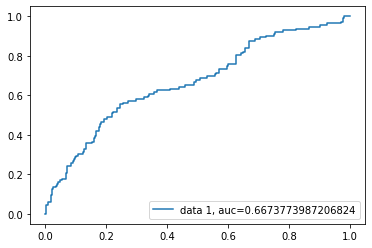

AUC: 0.667


In [37]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC:', round(auc,3))

# **Random Forest Classification**

I followed the tutorial here:  https://towardsdatascience.com/random-forest-in-python-24d0893d51c0 and https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

**Train the Model**

In [38]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Make Predictions on the Test Set**

In [39]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test)[:, 1]

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.31


**Evaluating the Performance**

For Classification Problems the metrics used to evaluate an algorithm are accuracy, confusion matrix, precision, recall, and F1 values.

We can also perform cross-fold validation to have a better understanding of the results

Reference: #https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652 

**ROC on the Full Data**


We make class predictions (predict) as well as predicted probabilities (predict_proba) to calculate the ROC AUC. Once we have the testing predictions, we can calculate the ROC AUC. https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [41]:
from sklearn.metrics import roc_auc_score

# Calculate ROC AUC
roc_value = roc_auc_score(y_test, rf_probs) 

roc_value

0.6201692430703625

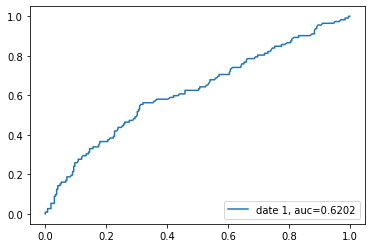

In [42]:
# Probabilities for each class
# Note from scikit learn: re fpr and tpr: "Since the thresholds are sorted from low to high values, they are reversed upon returning them to ensure they correspond to both fpr and tpr, which are sorted in reversed order during their calculation."
rf_probs = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_probs)
auc = metrics.roc_auc_score(y_test, rf_probs)
auc = round(auc, 4)
plt.plot(fpr, tpr, label="date 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**10 Cross-Fold Validation**

In [0]:
rfc_cv_score = cross_val_score(rf, x, y, cv=10, scoring='roc_auc') 

Below, we also can examine the confusion matrix, the classification report containing precision, recall, f1-score, and support, All AUC scores, and the mean AUC score

The **confusion matrix** is useful for giving false positives and false negatives

The **ROC Curve** plots out the true positive rate vs the false positive rate at various thresholds

The **ROC AUC Scoring** used in the cross-validation model shows the area under the ROC curve

In [44]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, predictions))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", accuracy_score(y_test, predictions))

=== Confusion Matrix ===
[[224  44]
 [ 74  38]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       268
         1.0       0.46      0.34      0.39       112

    accuracy                           0.69       380
   macro avg       0.61      0.59      0.59       380
weighted avg       0.67      0.69      0.67       380



=== All AUC Scores ===
[0.69790031 0.65678964 0.64540816 0.66365777 0.5998613  0.6825445
 0.603661   0.60032362 0.64037217 0.61165049]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.6402168970650247


=== Accuracy Score ===
Accuracy: 0.6894736842105263


# **Logistic Regression and Random Forest Results**

**Logistic Regression classifier:**

* AUC: 0.667
* Accuracy: 0.716
* Precision: 0.532
* Recall: 0.295


**Random Forest classifier:**

* AUC: 0.62
* AUC Mean 10 Fold Validation: 0.64
* Accuracy 10 Fold Validation: 0.689

# **PyTorch Neural Network For Classification**

We will evaluate the use of a neural network classifier on the testing data as developed above and compare the outputs to the logistic regression and random forest classifiers above. 

In [0]:
# Import PyTorch packages
import torch
from torch import nn
from torchvision import datasets, transforms
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F

**Format the Training Dataset**

In [0]:
# Convert data into arrays
xb = np.array(X_train, dtype = "float32")
yb = np.array(y_train, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Combine the arrays
trainloader = TensorDataset(xb, yb)

# Define the batchsize
batch_size = 32

# Training Loader
trainloader = DataLoader(trainloader, batch_size)

**Format the Testing Dataset**

In [0]:
# Convert data into arrays
xb = np.array(X_test, dtype = "float32")
yb = np.array(y_test, dtype = "float32")

# Convert arrays into tensors
xb = torch.from_numpy(xb)
yb = torch.from_numpy(yb)

# Combine the arrays
testloader = TensorDataset(xb, yb) 

# Define the batchsize
batch_size=32

# Training Loader
testloader = DataLoader(testloader, 
                         batch_size)

**Create Nueral Network Model**

In [81]:
# Define the model with hidden layers - 39 inputs
model = nn.Sequential(nn.Linear(39, 17),
                      nn.ReLU(),
                      nn.Linear(17, 8),
                      nn.ReLU(),
                      nn.Linear(8, 2),
                      nn.LogSoftmax(dim=1))

# Set optimizer and learning rate
#optimizer = optim.SGD(model.parameters(), lr=0.003)

# Could also use Adam optimizer; similar to stochastic gradient descent, but uses momentum which can speed up the actual fitting process, and it also adjusts the learning rate for each of the individual parameters in the model
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss
criterion = nn.NLLLoss()

# Set 100 epochs to start
epochs = 100
for e in range(epochs):
    running_loss = 0
    for xb, yb in trainloader:

        # Flatten yb
        #yb = yb.view(yb.shape[0], -1)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        # Training pass
        output = model.forward(xb)
        loss = criterion(output, yb.long()) # Loss calculated from the output compared to the labels 
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # loss.item() gets the scalar value held in the loss. Running_loss = 0, 
        # += notation, says "Add a value and the variable and assigns the result to that variable." So, adds the running_loss (0) with loss.item and assigns to running_loss
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.792359698149893
Training loss: 0.6507596886820264
Training loss: 0.6373953819274902
Training loss: 0.6249683764245775
Training loss: 0.6139739288224114
Training loss: 0.6041324353880353
Training loss: 0.5957684500349892
Training loss: 0.5891534412900606
Training loss: 0.584254850116041
Training loss: 0.5809597770373026
Training loss: 0.5784016590979364
Training loss: 0.5766752776172426
Training loss: 0.5750404720505079
Training loss: 0.5737773329019547
Training loss: 0.572724872165256
Training loss: 0.57187034520838
Training loss: 0.5710978284478188
Training loss: 0.5703391995694902
Training loss: 0.5697764870193269
Training loss: 0.5692222192883492
Training loss: 0.5686093486017652
Training loss: 0.5681199340356721
Training loss: 0.5676981343163384
Training loss: 0.5672707756360372
Training loss: 0.566877595252461
Training loss: 0.5665322351786826
Training loss: 0.5662054999007119
Training loss: 0.565899133682251
Training loss: 0.5655753637353579
Training loss: 0.5653

**Evaluation the Model**

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically, this is just accuracy, the percentage of classes the network predicted correctly. 

First, do a forward pass with one batch from the test set 

In [82]:
xb, yb = next(iter(testloader))

# Get the class probabilities 
ps = torch.exp(model(xb))

# Make sure the shape is appropriate
print(ps.shape)

torch.Size([32, 2])


With the probabilities, we can get the most likely class using the ps.topk method. This returns the k highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top-k values and the top-k indices. If the highest value is the first element, we'll get back 4 as the index. 

In [83]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 20 examples
print(top_class[:20,:])

tensor([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]])


In [0]:
top_p

In [0]:
ps[:20] #we can see how to correpsonding probabilities were classified above

Now we can check if the predicted classes match the labels. This is simple to do by equating top_class and labels, but we have to be careful of the shapes. To get the equality to work out the way we want, top_class and the labels (yb) must have the same shape.

In [84]:
equals = top_class == yb.view(*top_class.shape) 
equals

tensor([[False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]])

In [85]:
top_class = top_class.view(*yb.shape) 
top_class

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0])

In [0]:
# Cast top_class to float32
top_class = top_class.to(dtype=torch.float32)

Now we need to calculate the correct predictions. 

equals has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the total number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to torch.mean. 

So we'll need to convert equals to a float tensor. Note that when we take torch.mean it returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item()

**Edit: Can use accuracy metric below!**

In [87]:
#accuracy = torch.mean(equals.type(torch.FloatTensor))
#print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 68.75%


**Confusion Matrix**

The confusion matrix is conducted on the test batch created above.

In [88]:
# Calculating True Positive Rate (Sensitivity) and False Positive Rate (Sensitivity)
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

CM = confusion_matrix(yb, top_class)

TN = CM[0][0] # True Negative is high - is this because our model has greater sensitivty
FN = CM[1][0] # False Negative
TP = CM[1][1] # True Positive
FP = CM[0][1] # False POsitive 

CM

array([[20,  3],
       [ 7,  2]])

**Plot ROC of the Model**

**ROC Reference:** https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/

ROC area is 0.7


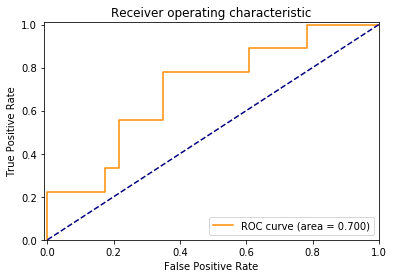

In [89]:
from sklearn.metrics import roc_curve, auc

top_p = top_p.detach().numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(yb, top_p, pos_label=1)

# Compute ROC area
roc_auc = round(auc(fpr, tpr),3)
print('ROC area is {0}'.format(roc_auc))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

**Confusion Matrix, Classification Report: Precission, Recall, F1, Accuracy**

In [90]:
print("=== Confusion Matrix ===")
print(confusion_matrix(yb, top_class))
print('\n')
print("=== Classification Report ===")
print(classification_report(yb, top_class))
print('\n')
print("=== Accuracy Score ===")
print("Accuracy:", accuracy_score(yb, top_class))

=== Confusion Matrix ===
[[20  3]
 [ 7  2]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80        23
         1.0       0.40      0.22      0.29         9

    accuracy                           0.69        32
   macro avg       0.57      0.55      0.54        32
weighted avg       0.64      0.69      0.66        32



=== Accuracy Score ===
Accuracy: 0.6875


# **Neural Network Results**

1) 1 Hidden Layer with 17 neurons, optimizer: SGD, lr = 0.001, epochs = 100

* AUC from ROC plot: 0.676
* Accuracy: 56%

2) 1 Hidden Layer with 17 neurons, optimizer: SGD, lr = 0.003, epochs = 100

* AUC from ROC plot: 0.691
* Accuracy: 56%

3) 1 Hidden Layer with 17 neurons, optimizer: Adam, lr = 0.001, epochs = 100

* AUC from ROC plot: 0.765
* Accuracy: 60%

**3) 1 Hidden Layer with 17 neurons, optimizer: Adam, lr = 0.003, epochs = 100**

* **AUC from ROC plot: 0.794**
* **Accuracy: 64%**

4) 1 Hidden Layer with 17 neurons, optimizer: Adam, lr = 0.004, epochs = 100

* AUC from ROC plot: 0.794
* Accuracy: 60%

5) 1 Hidden Layer with 17 neurons, optimizer: Adam, lr = 0.002, epochs = 100

* AUC from ROC plot: 0.756
* Accuracy: 56%

6) 2 Hidden Layer with 17, 8 neurons, optimizer: Adam, lr = 0.003, epochs = 100

* AUC from ROC plot: 0.669
* Accuracy: 56%

7) 3 Hidden Layer with 17, 8 neurons, optimizer: Adam, lr = 0.001, epochs = 100

* AUC from ROC plot: 0.765
* Accuracy: 60%

8) 3 Hidden Layer with 17, 8, 4 neurons, optimizer: Adam, lr = 0.001, epochs = 100

* AUC from ROC plot: 0.787
* Accuracy: 60%

9) 3 Hidden Layer with 17, 10, 4 neurons, optimizer: Adam, lr = 0.001, epochs = 100

* AUC from ROC plot:
* Accuracy: 

**Batch Size 32**

**10) 3 Hidden Layer with 17, 8 neurons, optimizer: Adam, lr = 0.001, epochs = 100**

* AUC from ROC plot: 0.70
* Accuracy: 0.6875 

=== Classification Report ===
   
                precision    recall  f1-score   support
         0.0       0.74      0.87      0.80        23
         1.0       0.40      0.22      0.29         9

    accuracy                           0.69        32
    macro avg       0.57     0.55      0.54        32
    weighted avg    0.64     0.69      0.66        32

# **Updates/Next Steps:**

**11.11.2019: Implemented the Neural Network models into the code and ran a few tests. Realized that I need to ensure that I am understanding the role of batch size. I also want to make sure I understand the following metrics: Accuracy, precision, recall, F1, AUC etc. I had run into problems with the AUC calucating, getting different results when I used top_p (probabilities) or top_class (binary predictions). From my reading, I am pretty sure we should be using probabilities in this calculation, which is good because it gives us much better results.**

**I will continue raeding up on the aforementioned metrics and review the code in regards to AUC. Potentially will experiement with Batch Size as well.**